In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import joblib  # Added for saving the model

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing & Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# --- Model Evaluation ---
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay

# --- Model Explainability ---
import shap

# --- Set Visualization Style ---
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the dataset
try:
    df = pd.read_csv('welldoc_diabetes_dataset.csv')
except FileNotFoundError:
    df = pd.read_csv('/kaggle/input/diabetes-welldoc-x-scope-vit-chennai/welldoc_diabetes_dataset.csv')

# Display basic information
print("--- Dataset Head ---")
print(df.head())
print("\n--- Dataset Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\n--- Descriptive Statistics ---")
print(df.describe())

--- Dataset Head ---
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               10000

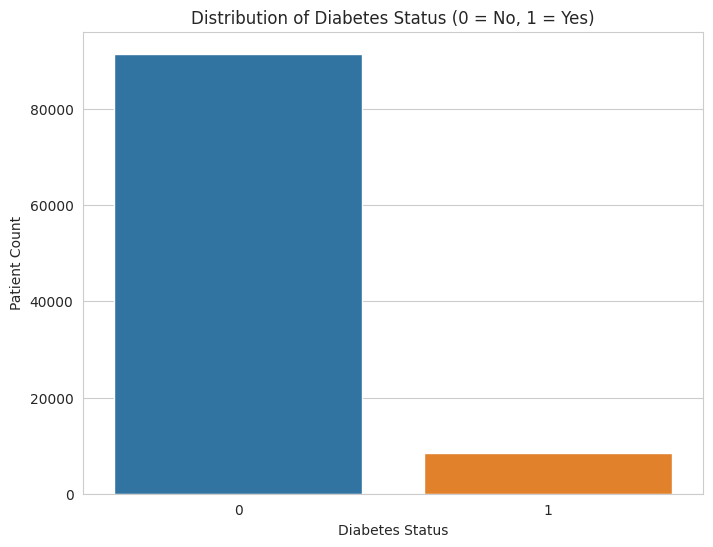

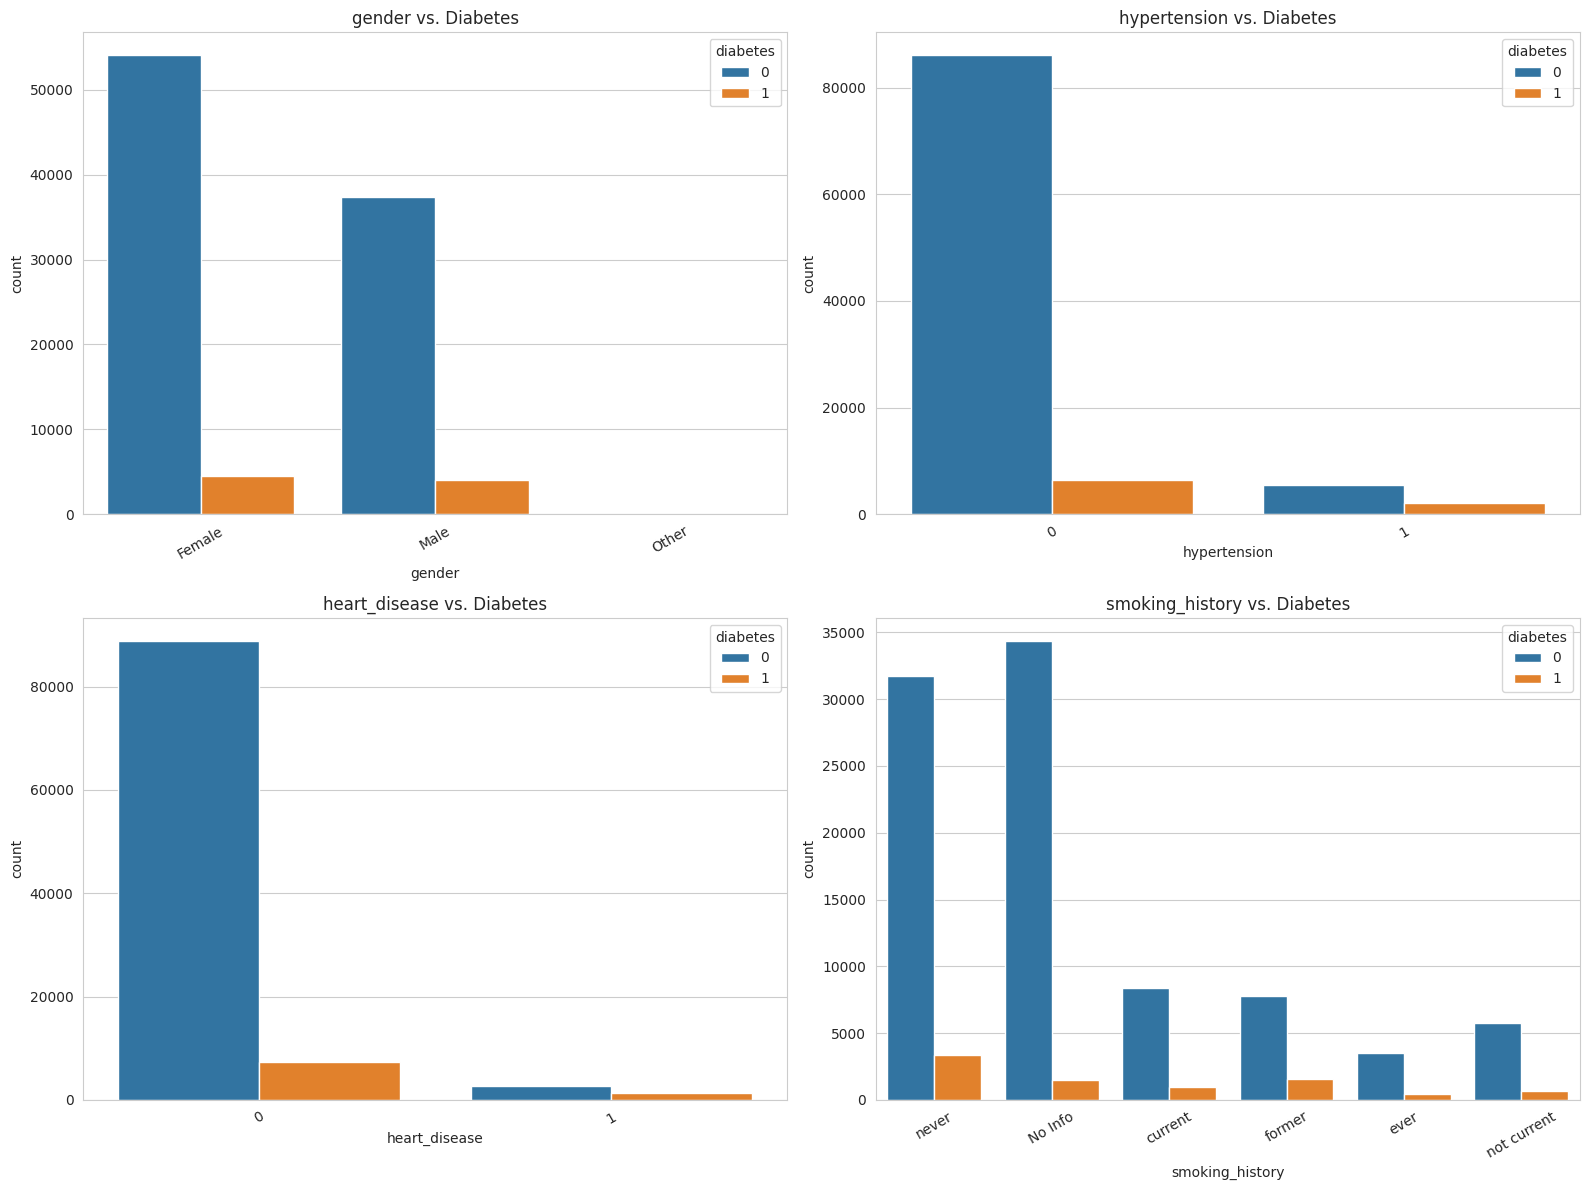

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na op

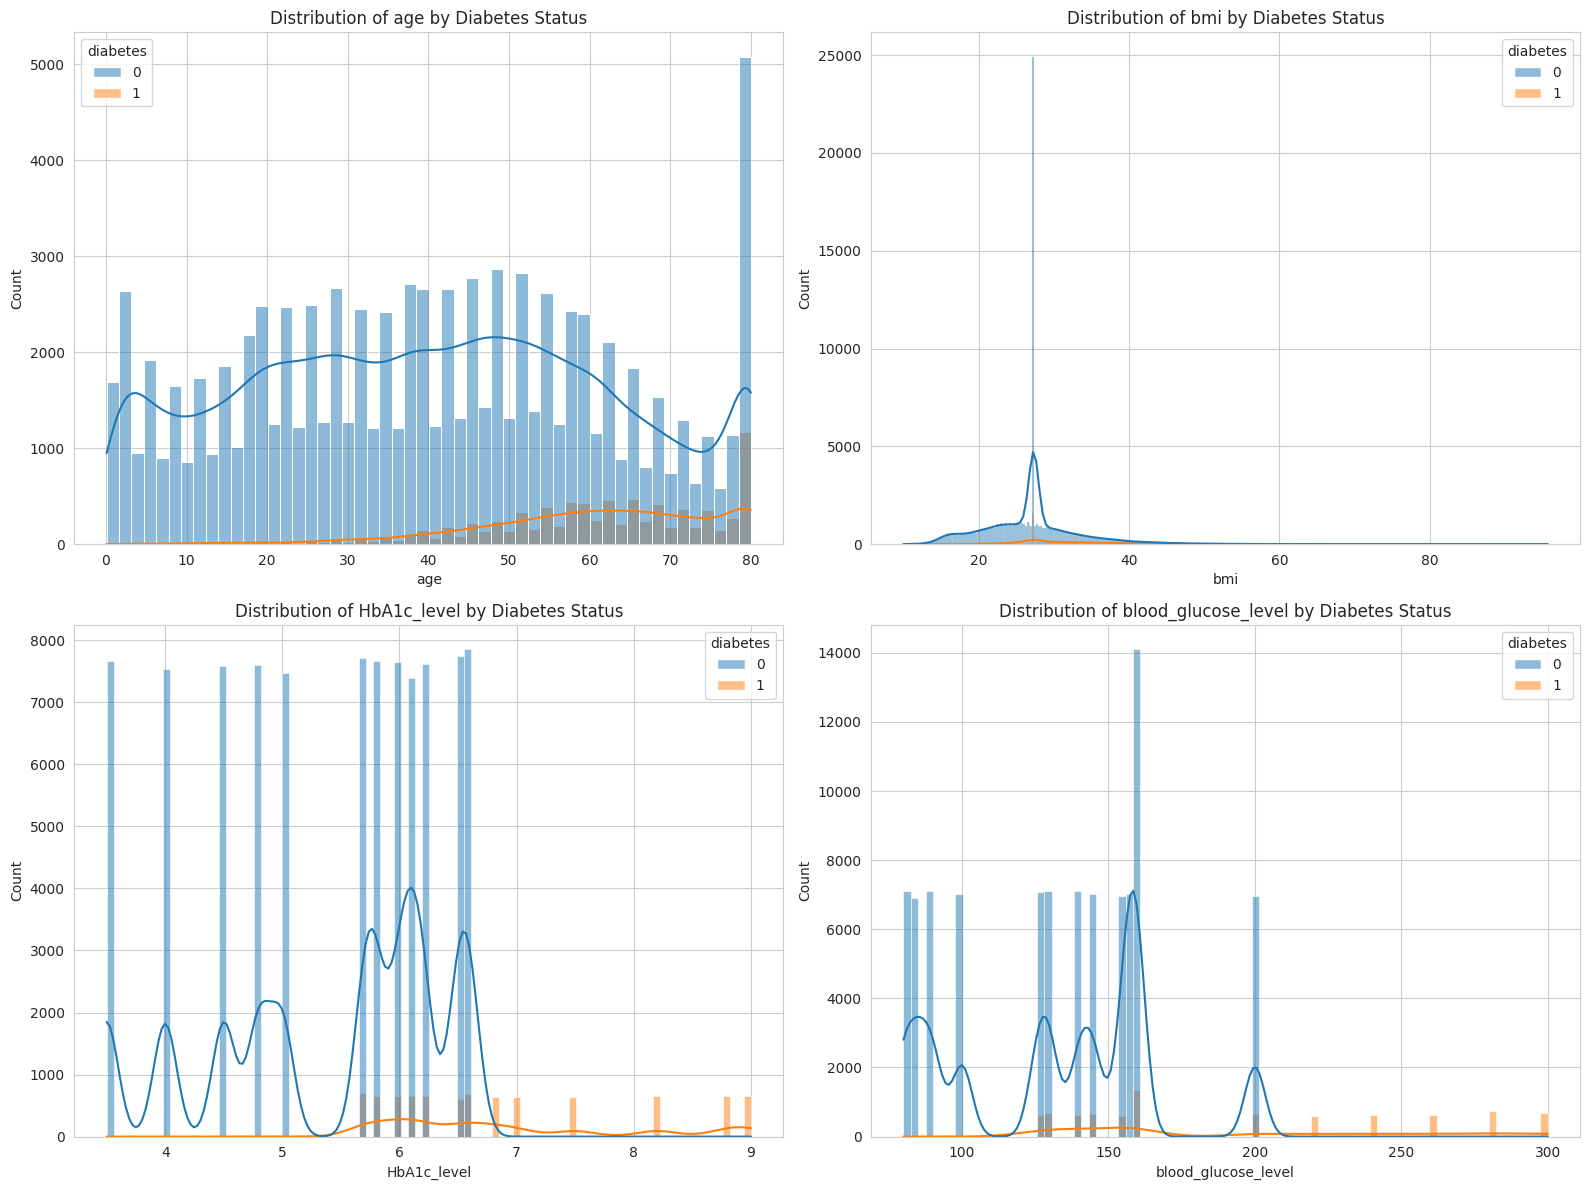

In [3]:
# 1. Target Variable Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes Status (0 = No, 1 = Yes)')
plt.xlabel('Diabetes Status')
plt.ylabel('Patient Count')
plt.savefig("diabetes_distribution.png")
plt.show()

# --- Analyze Categorical Features ---
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='diabetes', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs. Diabetes')
    axes[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig("categorical_features_vs_diabetes.png")
plt.show()


# --- Analyze Numerical Features ---
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.histplot(data=df, x=col, hue='diabetes', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Diabetes Status')
plt.tight_layout()
plt.savefig("numerical_features_vs_diabetes.png")
plt.show()

In [4]:
# Drop the 'Other' gender category as it has very few samples and can add noise
df = df[df['gender'] != 'Other']

# Define features (X) and target (y)
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Identify categorical and numerical features
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the scale_pos_weight for handling class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Create the full pipeline by combining the preprocessor and the model
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', xgb_model)])

# Train the model
print("Training the XGBoost model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Training the XGBoost model...
Model training complete.


--- Model Accuracy Score ---
The model has an accuracy of 0.9206


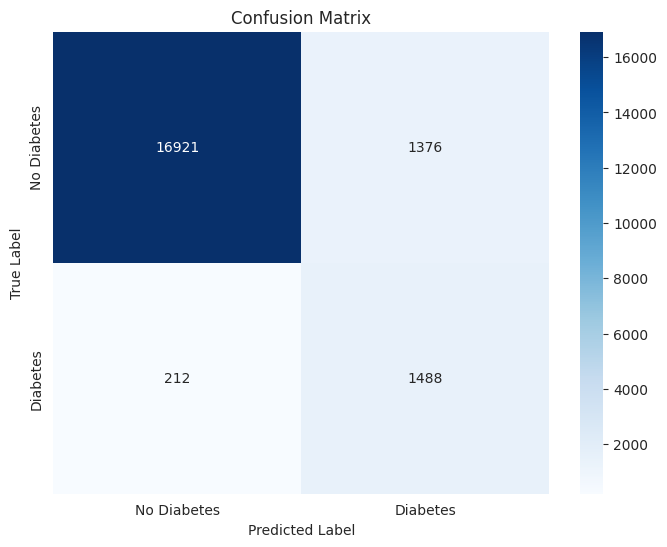


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     18297
           1       0.52      0.88      0.65      1700

    accuracy                           0.92     19997
   macro avg       0.75      0.90      0.80     19997
weighted avg       0.95      0.92      0.93     19997



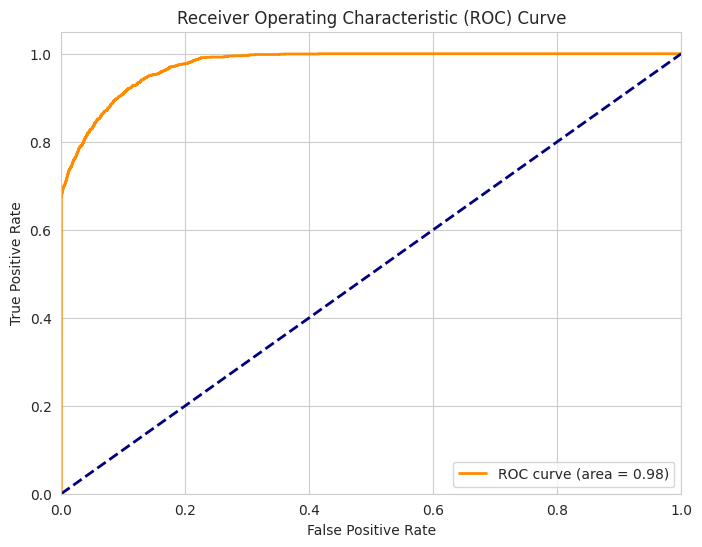

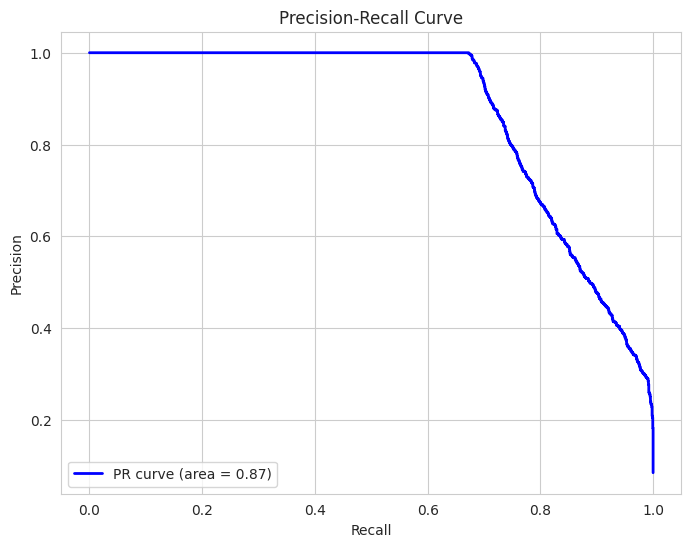

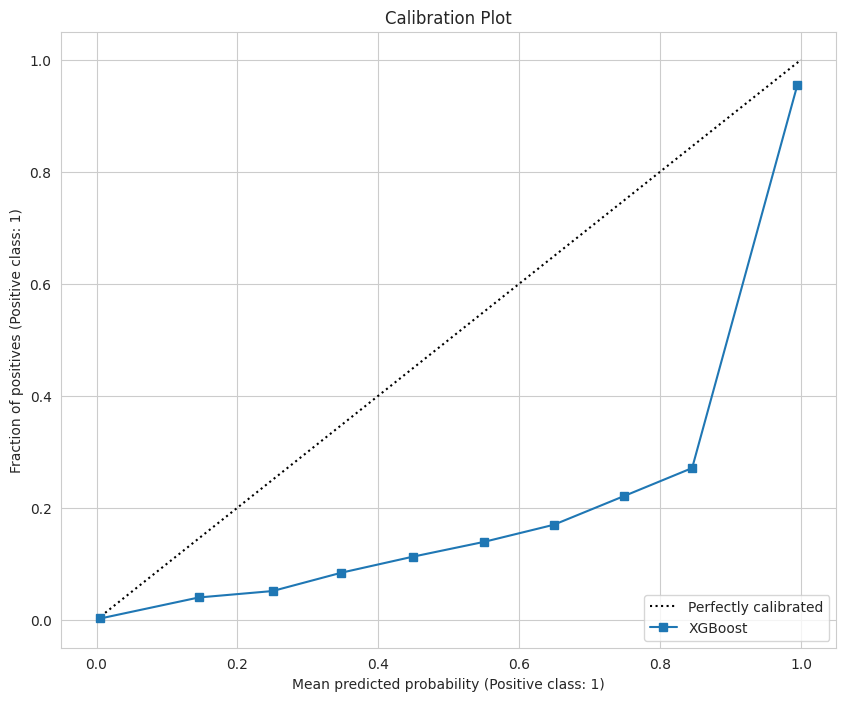

In [6]:
# Make predictions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# --- 0. Accuracy Score (NEW) ---
acc_score = accuracy_score(y_test, y_pred)
print(f"--- Model Accuracy Score ---")
print(f"The model has an accuracy of {acc_score:.4f}")

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("confusion_matrix.png")
plt.show()

# --- 2. Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- 3. AUROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()


# --- 4. AUPRC Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.savefig("precision_recall_curve.png")
plt.show()

# --- 5. Calibration Plot ---
plt.figure(figsize=(10, 8))
ax_cal = plt.gca()
CalibrationDisplay.from_predictions(y_test, y_pred_proba, n_bins=10, ax=ax_cal, name='XGBoost')
plt.title('Calibration Plot')
plt.savefig("calibration_plot.png")
plt.show()

In [7]:
# --- Save the Trained Model Pipeline ---
# The pipeline object contains both the preprocessing steps and the trained XGBoost model.
model_filename = 'diabetes_risk_prediction_model.joblib'
joblib.dump(model_pipeline, model_filename)

print(f"\nModel saved successfully as '{model_filename}'")
print("\nYou can now load this file to make predictions on new patient data.")

# Example of how to load and use the model later:
# loaded_model = joblib.load('diabetes_risk_prediction_model.joblib')
# new_predictions = loaded_model.predict(new_patient_data)


Model saved successfully as 'diabetes_risk_prediction_model.joblib'

You can now load this file to make predictions on new patient data.



--- Global Feature Importance (SHAP Summary Plot) ---


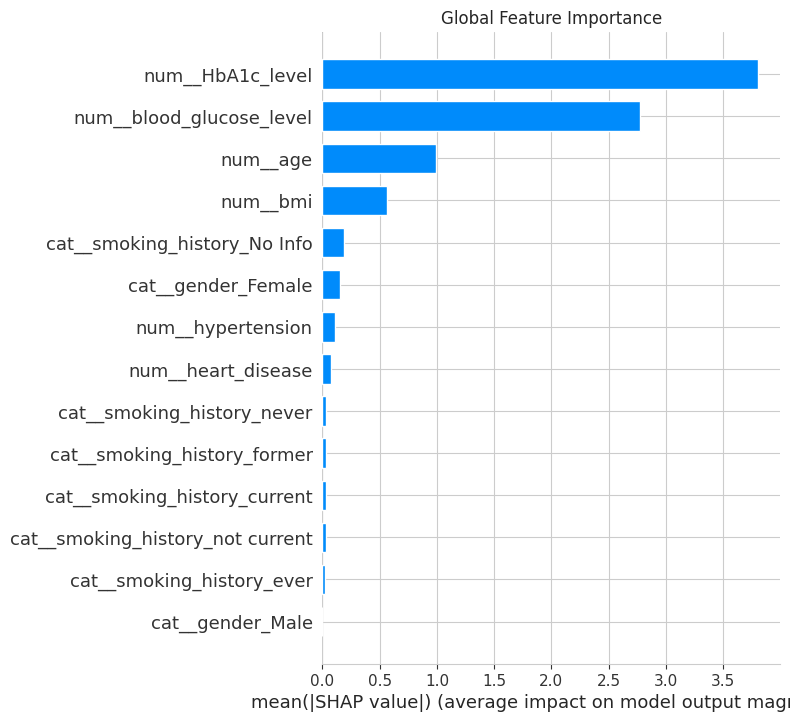


--- Feature Impact on Model Output (SHAP Beeswarm Plot) ---


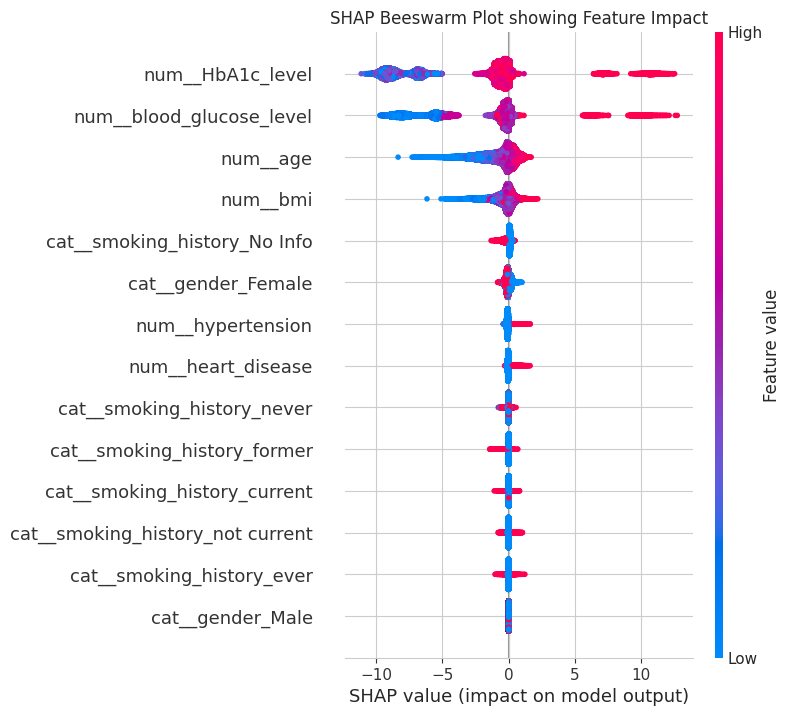


--- Local Explanation for a High-Risk Patient (Patient Index: 1) ---


In [8]:
# --- Setup SHAP ---
X_train_processed = model_pipeline.named_steps['preprocessor'].transform(X_train)
explainer = shap.TreeExplainer(model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_processed)

feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

# --- 1. Global Explainability: Feature Importance ---
print("\n--- Global Feature Importance (SHAP Summary Plot) ---")
shap.summary_plot(shap_values, X_train_processed_df, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.savefig("shap_global_importance.png")
plt.show()

print("\n--- Feature Impact on Model Output (SHAP Beeswarm Plot) ---")
shap.summary_plot(shap_values, X_train_processed_df, show=False)
plt.title("SHAP Beeswarm Plot showing Feature Impact")
plt.savefig("shap_beeswarm_plot.png")
plt.show()

# --- 2. Local Explainability: Explaining a Single Prediction ---
X_test_processed = model_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)
high_risk_idx = np.where(y_pred == 1)[0][0]

print(f"\n--- Local Explanation for a High-Risk Patient (Patient Index: {high_risk_idx}) ---")
shap.initjs()
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test_processed_df.iloc[[high_risk_idx]]),
                X_test_processed_df.iloc[[high_risk_idx]])